# Affine transforms
Here we compare performance of affine transforms implemented in [cupy](https://cupy.dev), [scipy](https://scipy.org) and clEsperanto

**Note:** benchmarking results vary heavily depending on image size, kernel size, used operations, parameters and used hardware. Use this notebook to adapt it to your use-case scenario and benchmark on your target hardware. If you have different scenarios or use-cases, you are very welcome to submit your notebook as pull-request!

In [1]:
import pyclesperanto_prototype as cle

# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.set_wait_for_kernel_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('RTX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [2]:
from skimage.io import imread, imshow
image = imread('../data/Haase_MRT_tfl3d1.tif')[60]

(160, 160)

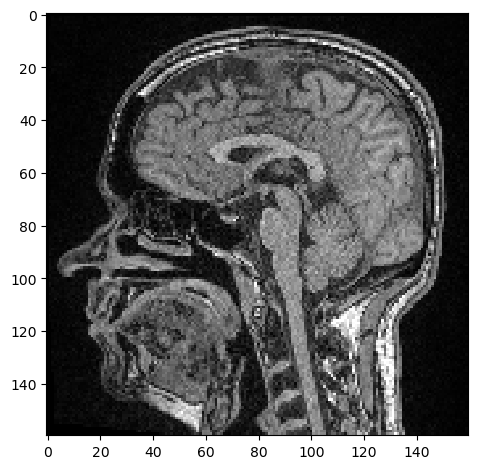

In [3]:
imshow(image)
image.shape

In [4]:
import numpy as np

# scaling by factor 1 / s
s = 0.025
matrix = np.asarray([
    [s, 0, 0],
    [0, s, 0],
    [0, 0, 1],
])
output_shape = tuple((np.asarray(image.shape) / s).astype(int))
print(output_shape)


(6400, 6400)


## cupy

cupy affine transform duration: 0.2583317756652832
cupy affine transform duration: 0.11034011840820312
cupy affine transform duration: 0.11318802833557129
cupy affine transform duration: 0.11770057678222656
cupy affine transform duration: 0.11446738243103027
cupy affine transform duration: 0.11156678199768066
cupy affine transform duration: 0.1072547435760498
cupy affine transform duration: 0.10671854019165039
cupy affine transform duration: 0.11817169189453125
cupy affine transform duration: 0.10398268699645996


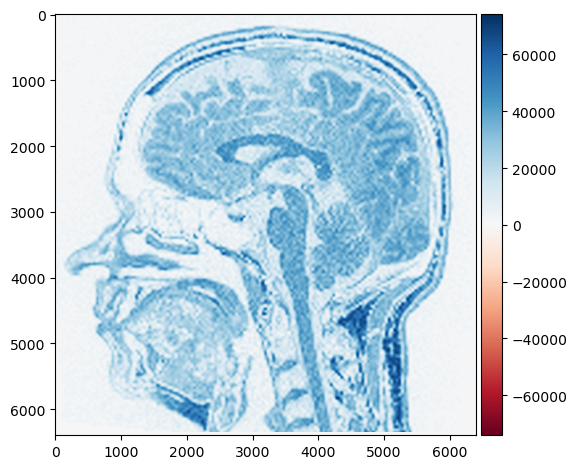

In [5]:
import time
import cupy
from cupyx.scipy import ndimage as ndi

cuda_image = cupy.asarray(image)

cuda_scaled = cupy.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    ndi.affine_transform(cuda_image, cupy.asarray(matrix), output=cuda_scaled, output_shape=output_shape)
    cupy.cuda.stream.get_current_stream().synchronize() # we need to wait here to measure time properly
    print("cupy affine transform duration: " + str(time.time() - start_time))
          
result = cupy.asnumpy(cuda_scaled)
imshow(result)

## clEsperanto

In [6]:
ocl_image = cle.push(image)

ocl_scaled = cle.create(output_shape)
for i in range(0, 10):
    start_time = time.time()
    cle.affine_transform(ocl_image, ocl_scaled, transform=np.linalg.inv(matrix), linear_interpolation=True)
    print("clEsperanto affine transform duration: " + str(time.time() - start_time))

result = cle.pull(ocl_scaled)
imshow(result)

Executing affine_transform_3d_interpolate_x.cl


RuntimeError: clBuildProgram failed: BUILD_PROGRAM_FAILURE - clBuildProgram failed: BUILD_PROGRAM_FAILURE - clBuildProgram failed: BUILD_PROGRAM_FAILURE

Build on <pyopencl.Device 'NVIDIA GeForce RTX 3050 Ti Laptop GPU' on 'NVIDIA CUDA' at 0x169dc1c1f70>:

<kernel>:37:26: warning: unknown OpenCL extension 'cl_amd_printf' - ignoring
#pragma OPENCL EXTENSION cl_amd_printf : enable
                         ^
<kernel>:605:16: warning: implicit conversion from 'long long' to 'uint' (aka 'unsigned int') changes value from 18446744073709551615 to 4294967295
        return 18446744073709551615;
        ~~~~~~ ^~~~~~~~~~~~~~~~~~~~
<kernel>:615:16: warning: implicit conversion from 'long' to 'int' changes value from 9223372036854775807 to -1
        return 9223372036854775807;
        ~~~~~~ ^~~~~~~~~~~~~~~~~~~
<kernel>:618:16: warning: implicit conversion from 'long long' to 'int' changes value from -9223372036854775808 to 0
        return -9223372036854775808 ;
        ~~~~~~ ^~~~~~~~~~~~~~~~~~~~
<kernel>:707:23: error: no matching function for call to 'read_imagef'
  float pix = (float)(READ_input_IMAGE(input, sampler, coord_norm).x);
                      ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<kernel>:12:33: note: expanded from macro 'READ_input_IMAGE'
#define READ_input_IMAGE(a,b,c) read_imagef(a,b,c)
                                ^~~~~~~~~~~
cl_kernel.h:18695:25: note: candidate function not viable: no known conversion from 'float4' (vector of 4 'float' values) to 'int2' (vector of 2 'int' values) for 3rd argument
float4 __OVERLOADABLE__ read_imagef(read_only image2d_t image, sampler_t sampler, int2 coord);
                        ^
cl_kernel.h:18696:25: note: candidate function not viable: no known conversion from 'float4' (vector of 4 'float' values) to 'float2' (vector of 2 'float' values) for 3rd argument
float4 __OVERLOADABLE__ read_imagef(read_only image2d_t image, sampler_t sampler, float2 coord);
                        ^
cl_kernel.h:18698:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image3d_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_only image3d_t image, sampler_t sampler, float4 coord);
                        ^
cl_kernel.h:18714:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image3d_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_write image3d_t image, sampler_t sampler, float4 coord);
                        ^
cl_kernel.h:18734:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image2d_array_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_only image2d_array_t image, sampler_t sampler, float4 coord);
                        ^
cl_kernel.h:18742:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image2d_array_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_write image2d_array_t image, sampler_t sampler, float4 coord);
                        ^
cl_kernel.h:18784:24: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image2d_array_depth_t' for 1st argument
float __OVERLOADABLE__ read_imagef(read_only image2d_array_depth_t image, sampler_t sampler, float4 coord);
                       ^
cl_kernel.h:18790:24: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image2d_array_depth_t' for 1st argument
float __OVERLOADABLE__ read_imagef(read_write image2d_array_depth_t image, sampler_t sampler, float4 coord);
                       ^
cl_kernel.h:18697:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image3d_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_only image3d_t image, sampler_t sampler, int4 coord);
                        ^
cl_kernel.h:18711:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image2d_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_write image2d_t image, sampler_t sampler, int2 coord);
                        ^
cl_kernel.h:18712:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image2d_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_write image2d_t image, sampler_t sampler, float2 coord);
                        ^
cl_kernel.h:18713:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image3d_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_write image3d_t image, sampler_t sampler, int4 coord);
                        ^
cl_kernel.h:18729:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image1d_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_only image1d_t image, sampler_t sampler, int coord);
                        ^
cl_kernel.h:18730:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image1d_array_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_only image1d_array_t image, sampler_t sampler, int2 coord);
                        ^
cl_kernel.h:18731:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image1d_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_only image1d_t image, sampler_t sampler, float coord);
                        ^
cl_kernel.h:18732:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image1d_array_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_only image1d_array_t image, sampler_t sampler, float2 coord);
                        ^
cl_kernel.h:18733:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image2d_array_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_only image2d_array_t image, sampler_t sampler, int4 coord);
                        ^
cl_kernel.h:18737:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image1d_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_write image1d_t image, sampler_t sampler, int coord);
                        ^
cl_kernel.h:18738:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image1d_array_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_write image1d_array_t image, sampler_t sampler, int2 coord);
                        ^
cl_kernel.h:18739:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image1d_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_write image1d_t image, sampler_t sampler, float coord);
                        ^
cl_kernel.h:18740:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image1d_array_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_write image1d_array_t image, sampler_t sampler, float2 coord);
                        ^
cl_kernel.h:18741:25: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image2d_array_t' for 1st argument
float4 __OVERLOADABLE__ read_imagef(read_write image2d_array_t image, sampler_t sampler, int4 coord);
                        ^
cl_kernel.h:18781:24: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image2d_depth_t' for 1st argument
float __OVERLOADABLE__ read_imagef(read_only image2d_depth_t image, sampler_t sampler, int2 coord);
                       ^
cl_kernel.h:18782:24: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image2d_depth_t' for 1st argument
float __OVERLOADABLE__ read_imagef(read_only image2d_depth_t image, sampler_t sampler, float2 coord);
                       ^
cl_kernel.h:18783:24: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_only image2d_array_depth_t' for 1st argument
float __OVERLOADABLE__ read_imagef(read_only image2d_array_depth_t image, sampler_t sampler, int4 coord);
                       ^
cl_kernel.h:18787:24: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image2d_depth_t' for 1st argument
float __OVERLOADABLE__ read_imagef(read_write image2d_depth_t image, sampler_t sampler, int2 coord);
                       ^
cl_kernel.h:18788:24: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image2d_depth_t' for 1st argument
float __OVERLOADABLE__ read_imagef(read_write image2d_depth_t image, sampler_t sampler, float2 coord);
                       ^
cl_kernel.h:18789:24: note: candidate function not viable: no known conversion from '__read_only image2d_t' to '__read_write image2d_array_depth_t' for 1st argument
float __OVERLOADABLE__ read_imagef(read_write image2d_array_depth_t image, sampler_t sampler, int4 coord);
                       ^
cl_kernel.h:18831:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_write image3d_t image, int4 coord);
                        ^
cl_kernel.h:18830:24: note: candidate function not viable: requires 2 arguments, but 3 were provided
float __OVERLOADABLE__ read_imagef(read_write image2d_depth_t image, int2 coord);
                       ^
cl_kernel.h:18829:24: note: candidate function not viable: requires 2 arguments, but 3 were provided
float __OVERLOADABLE__ read_imagef(read_write image2d_array_depth_t image, int4 coord);
                       ^
cl_kernel.h:18828:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_write image2d_array_t image, int4 coord);
                        ^
cl_kernel.h:18827:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_write image2d_t image, int2 coord);
                        ^
cl_kernel.h:18824:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_only image3d_t image, int4 coord);
                        ^
cl_kernel.h:18823:24: note: candidate function not viable: requires 2 arguments, but 3 were provided
float __OVERLOADABLE__ read_imagef(read_only image2d_depth_t image, int2 coord);
                       ^
cl_kernel.h:18822:24: note: candidate function not viable: requires 2 arguments, but 3 were provided
float __OVERLOADABLE__ read_imagef(read_only image2d_array_depth_t image, int4 coord);
                       ^
cl_kernel.h:18821:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_only image2d_array_t image, int4 coord);
                        ^
cl_kernel.h:18820:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_only image2d_t image, int2 coord);
                        ^
cl_kernel.h:18811:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_write image1d_buffer_t image, int coord);
                        ^
cl_kernel.h:18810:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_write image1d_array_t image, int2 coord);
                        ^
cl_kernel.h:18809:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_write image1d_t image, int coord);
                        ^
cl_kernel.h:18800:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_only image1d_buffer_t image, int coord);
                        ^
cl_kernel.h:18799:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_only image1d_array_t image, int2 coord);
                        ^
cl_kernel.h:18798:25: note: candidate function not viable: requires 2 arguments, but 3 were provided
float4 __OVERLOADABLE__ read_imagef(read_only image1d_t image, int coord);
                        ^
cl_kernel.h:18968:1: note: candidate function not viable: requires 4 arguments, but 3 were provided
read_imagef(read_only image2d_array_depth_t image, sampler_t sampler, float4 coord,
^
cl_kernel.h:18956:1: note: candidate function not viable: requires 4 arguments, but 3 were provided
read_imagef(read_only image2d_array_t image, sampler_t sampler, float4 coord,
^
cl_kernel.h:18932:1: note: candidate function not viable: requires 4 arguments, but 3 were provided
read_imagef(read_only image1d_array_t image, sampler_t sampler, float2 coord,
^
cl_kernel.h:18911:1: note: candidate function not viable: requires 4 arguments, but 3 were provided
read_imagef(read_only image3d_t image, sampler_t sampler, float4 coord, float lod);
^
cl_kernel.h:18889:1: note: candidate function not viable: requires 4 arguments, but 3 were provided
read_imagef(read_only image1d_t image, sampler_t sampler, float coord, float lod);
^
cl_kernel.h:18870:1: note: candidate function not viable: requires 4 arguments, but 3 were provided
read_imagef(read_only image2d_depth_t image, sampler_t sampler, float2 coord, float lod);
^
cl_kernel.h:18861:1: note: candidate function not viable: requires 4 arguments, but 3 were provided
read_imagef(read_only image2d_t image, sampler_t sampler, float2 coord, float lod);
^
cl_kernel.h:18984:1: note: candidate function not viable: requires 5 arguments, but 3 were provided
read_imagef(read_only image2d_array_depth_t image, sampler_t sampler, float4 coord,
^
cl_kernel.h:18972:1: note: candidate function not viable: requires 5 arguments, but 3 were provided
read_imagef(read_only image2d_array_t image, sampler_t sampler, float4 coord,
^
cl_kernel.h:18944:1: note: candidate function not viable: requires 5 arguments, but 3 were provided
read_imagef(read_only image1d_array_t image, sampler_t sampler, float2 coord,
^
cl_kernel.h:18920:1: note: candidate function not viable: requires 5 arguments, but 3 were provided
read_imagef(read_only image3d_t image, sampler_t sampler, float4 coord,
^
cl_kernel.h:18899:1: note: candidate function not viable: requires 5 arguments, but 3 were provided
read_imagef(read_only image1d_t image, sampler_t sampler, float coord,
^
cl_kernel.h:18885:1: note: candidate function not viable: requires 5 arguments, but 3 were provided
read_imagef(read_only image2d_depth_t image, sampler_t sampler, float2 coord,
^
cl_kernel.h:18873:1: note: candidate function not viable: requires 5 arguments, but 3 were provided
read_imagef(read_only image2d_t image, sampler_t sampler, float2 coord,
^

(options: -I C:\Users\haase\mambaforge\envs\bio39\lib\site-packages\pyopencl\cl)
(source saved as C:\Users\haase\AppData\Local\Temp\tmplzoaxzab.cl)

## Scipy

In [ ]:
import time
from scipy import ndimage as sndi

scaled = np.ndarray(output_shape)
for i in range(0, 10):
    start_time = time.time()
    sndi.affine_transform(image, matrix, output=scaled, output_shape=output_shape)
    print("scipy affine transform duration: " + str(time.time() - start_time))

imshow(scaled[120])